In [1]:
import torch
from torch.autograd import Variable

In [2]:
import glob
all_filenames = glob.glob('./data/names/*.txt')
print(all_filenames)

['./data/names/Korean.txt', './data/names/Portuguese.txt', './data/names/Vietnamese.txt', './data/names/Greek.txt', './data/names/Spanish.txt', './data/names/Polish.txt', './data/names/Russian.txt', './data/names/Scottish.txt', './data/names/German.txt', './data/names/Irish.txt', './data/names/Japanese.txt', './data/names/English.txt', './data/names/Chinese.txt', './data/names/Italian.txt', './data/names/French.txt', './data/names/Czech.txt', './data/names/Arabic.txt', './data/names/Dutch.txt']


In [3]:
import unicodedata
import string

In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [5]:
category_lines.keys()

dict_keys(['Korean', 'Portuguese', 'Vietnamese', 'Greek', 'Spanish', 'Polish', 'Russian', 'Scottish', 'German', 'Irish', 'Japanese', 'English', 'Chinese', 'Italian', 'French', 'Czech', 'Arabic', 'Dutch'])

In [6]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i


In [7]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

# for i in range(3):
#     category, line, category_tensor, line_tensor = random_training_pair()
#     x.append(line_tensor.unsqueeze(1))
#     y.append(category_tensor.unsqueeze(0))

    

In [38]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initiate nn.Linear modules
        """
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_hidden = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.input_output = torch.nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = torch.nn.LogSoftmax()
        
    def forward(self, x, hidden):
        """
        Get your Varible and return prediction
        """
        inandhidden = torch.cat((x, hidden), 1)
        hidden = self.input_hidden(inandhidden)
        output = self.input_output(inandhidden)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [39]:
n_letters = 57
n_hidden = 128
n_categories = 18
batch_size, input_size, hidden_size, output_size = 1, n_letters, n_hidden, n_categories
learning_rate = 0.005  # 1e-6 is too small here with nn

In [12]:
# x = Variable(torch.randn(batch_size, input_size), requires_grad = False) # False is default
# y = Variable(torch.randn(batch_size, output_size), requires_grad = False)

In [84]:
# model = torch.nn.Sequential(
#         torch.nn.Linear(input_size, hidden_size),
#         torch.nn.ReLU(),
#         torch.nn.Linear(hidden_size, output_size))
model  = RNN(input_size, hidden_size, output_size)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [97]:
n_epoch=30000

In [94]:
# def train(line_tensor, category_tensor):
#     model.zero_grad()
#     hidden = model.init_hidden()
    
#     for i in range(line_tensor.size()[0]):
#         output, hidden = model(line_tensor[i], hidden)

#     loss = loss_fn(output, category_tensor)
#     loss.backward()

#     optimizer.step()

#     return output, loss.data

In [99]:
all_losses = []
current_loss=0

for epoch in range(1, n_epoch+1):
    category, line, category_tensor, line_tensor = random_training_pair()
#     output, loss = train(line_tensor, category_tensor)

    model.zero_grad()
    hidden = model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)
    loss.backward()

    optimizer.step()
    
    current_loss += loss
#     print(current_loss)
#     print(category ,line)
    
    if epoch % 100 == 0 :
        all_losses.append(current_loss/100)
        print('(%d epoch) line = %s, category = %s, loss = %f' %(epoch, line, category, current_loss/100))
        current_loss = 0
#     model.zero_grad()
#     # initialize hidden
#     hidden = model.init_hidden()

#     # forward
#     for i in range(line_tensor.size()[0]):
#         output, hidden = model(line_tensor[i], hidden)

#     # loss
#     loss = loss_fn(output, category_tensor)
# #     current_loss += loss
# #     all_losses.append(loss)
#     #     print('i = %d, loss = %d' %(i, loss.data))

#     # backward
# #     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
# #     current_loss += loss
#     all_losses.append(loss.data)
# # all_losses.append(loss)

/home/hansol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(0 epoch) line = Kelly, category = Scottish, loss = 0.027138
(100 epoch) line = Shum, category = Chinese, loss = 2.332273
(200 epoch) line = Cheng, category = Chinese, loss = 2.376939
(300 epoch) line = Mcdonald, category = Scottish, loss = 2.303998
(400 epoch) line = Stewart, category = Scottish, loss = 2.368918
(500 epoch) line = Zhou, category = Chinese, loss = 2.264059
(600 epoch) line = Gerges, category = Arabic, loss = 2.331577
(700 epoch) line = Macdermott, category = Irish, loss = 2.271971
(800 epoch) line = Le, category = Vietnamese, loss = 2.292868
(900 epoch) line = Garrastazu, category = Spanish, loss = 2.358690
(1000 epoch) line = Delacroix, category = French, loss = 2.396186
(1100 epoch) line = Hughes, category = Scottish, loss = 2.271761
(1200 epoch) line = Than, category = Vietnamese, loss = 2.188111
(1300 epoch) line = Watabe, category = Japanese, loss = 2.295599
(1400 epoch) line = Pham, category = Vietnamese, loss = 2.220715
(1500 epoch) line = Adamyan, category = Ru

(12900 epoch) line = Wallace, category = Scottish, loss = 1.848470
(13000 epoch) line = Meszes, category = Czech, loss = 1.819181
(13100 epoch) line = Bock, category = Czech, loss = 1.885533
(13200 epoch) line = Poirier, category = French, loss = 1.929019
(13300 epoch) line = Mondo, category = Italian, loss = 1.797093
(13400 epoch) line = Gagnier, category = French, loss = 1.965673
(13500 epoch) line = Abbatantuono, category = Italian, loss = 1.706893
(13600 epoch) line = Pieha, category = Russian, loss = 1.796616
(13700 epoch) line = Chlebek, category = Polish, loss = 1.746200
(13800 epoch) line = Harb, category = Arabic, loss = 1.988397
(13900 epoch) line = Kasprzak, category = Polish, loss = 1.853704
(14000 epoch) line = Jian, category = Chinese, loss = 1.830222
(14100 epoch) line = Fournier, category = French, loss = 1.770610
(14200 epoch) line = Kucera, category = Czech, loss = 1.723994
(14300 epoch) line = Buonarroti, category = Italian, loss = 1.981608
(14400 epoch) line = Assaf

(25600 epoch) line = Doan, category = Vietnamese, loss = 1.661199
(25700 epoch) line = Faraldo, category = Italian, loss = 1.657881
(25800 epoch) line = Jamieson, category = Scottish, loss = 1.694365
(25900 epoch) line = Sandoval, category = Spanish, loss = 1.569478
(26000 epoch) line = Araullo, category = Portuguese, loss = 1.609543
(26100 epoch) line = Yin, category = Chinese, loss = 1.708648
(26200 epoch) line = Fillipova, category = Czech, loss = 1.567159
(26300 epoch) line = Pawlak, category = Czech, loss = 1.624823
(26400 epoch) line = Bishara, category = Arabic, loss = 1.586995
(26500 epoch) line = Legrand, category = French, loss = 1.750380
(26600 epoch) line = Close, category = Greek, loss = 1.679072
(26700 epoch) line = Kolijn, category = Dutch, loss = 1.705884
(26800 epoch) line = Salvatici, category = Italian, loss = 1.614200
(26900 epoch) line = Moon, category = Korean, loss = 1.602431
(27000 epoch) line = Koo, category = Chinese, loss = 1.513452
(27100 epoch) line = Dinh,

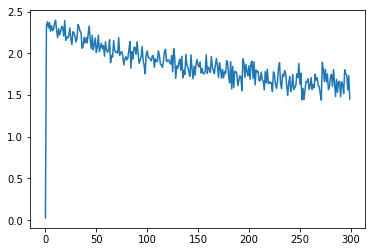

In [100]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure()
plt.plot(all_losses)

something is going!